In [1]:
# Food Ingredient Prediction with GPT-4
# Zero-shot and Few-shot Learning

import os
import json
import random
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from openai import OpenAI
from dotenv import load_dotenv
from PIL import Image
from IPython.display import display
import base64

# caching
import hashlib
import pickle
from diskcache import Cache

cache = Cache("./gpt4_cache")

In [2]:
# LLM Tracing

from traceloop.sdk import Traceloop

Traceloop.init()

Traceloop syncing configuration and prompts
Traceloop exporting traces to https://api.traceloop.com authenticating with bearer token



In [3]:
# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [4]:
# ==== Visualization Parameters
# Define colors [zero-shot, few-shot, many-shot]
colors_gpt4o_mini = ['#FFA07A', '#FA8072', '#CD5C5C']
colors_gpt4o = ['#87CEFA', '#1E90FF', '#4169E1']

In [5]:
# Load and prepare data
def load_data(file_path):
    with open(file_path, 'r') as f:
        return [json.loads(line) for line in f]

train_data = load_data('food-ingredients-101/train.jsonl')
test_data = load_data('food-ingredients-101/test.jsonl')

# show 4 examples from the training set
# [{'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1005649.jpg'}, {'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1014775.jpg'}, {'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1026328.jpg'}, {'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1028787.jpg'}]
def show_examples(data):
    from IPython.display import display, HTML
    html_content = ""
    for i in range(3):
        image = Image.open(data[i]['image'])
        image = image.resize((256, 256))
        caption = data[i]['suffix']
        wrapped_caption = '<br>'.join([caption[i:i+50] for i in range(0, len(caption), 50)])
        html_content += f"<img src='{data[i]['image']}' style='width: 256px; height: 256px; margin: 10px;'><div style='display: inline-block; vertical-align: top; margin: 10px; max-width: 256px;'><p>{wrapped_caption}</p></div>"
    display(HTML(html_content))

show_examples(train_data)

In [6]:
# Helper functions for evaluation

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

def preprocess_ingredients(ingredient_string):
    return set(ingredient_string.lower().split(', '))

def ingredient_overlap_f1_sklearn(references, candidates, method):
    mlb = MultiLabelBinarizer()
    
    all_ingredients = set()
    for ref, cand in zip(references, candidates):
        all_ingredients.update(preprocess_ingredients(ref))
        all_ingredients.update(preprocess_ingredients(cand))
    
    mlb.fit([all_ingredients])
    
    y_true = mlb.transform([preprocess_ingredients(ref) for ref in references])
    y_pred = mlb.transform([preprocess_ingredients(cand) for cand in candidates])
    
    if method == 'sklearn':
        return np.mean([f1_score(yt, yp, average='binary', zero_division=0) for yt, yp in zip(y_true, y_pred)])
    elif method in ['weighted', 'macro', 'samples']:
        return f1_score(y_true, y_pred, average=method, zero_division=0)
    else:
        raise ValueError("Invalid method. Choose 'sklearn', 'weighted', 'macro', or 'samples'.")

def calculate_accuracy(ground_truths, predictions):
    total_correct = 0
    total_ingredients = 0
    
    for gt, pred in zip(ground_truths, predictions):
        gt_ingredients = preprocess_ingredients(gt)
        pred_ingredients = preprocess_ingredients(pred)
        
        correct = len(gt_ingredients.intersection(pred_ingredients))
        total_correct += correct
        total_ingredients += len(gt_ingredients)
    
    return total_correct / total_ingredients if total_ingredients > 0 else 0

def calculate_bleu(reference, hypothesis):
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=SmoothingFunction().method1)

rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = rouge_scorer_obj.score(reference, hypothesis)
    return (scores['rouge1'].fmeasure + scores['rouge2'].fmeasure + scores['rougeL'].fmeasure) / 3


In [7]:
# function for checking valid img data
def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            # Check file format
            if img.format.lower() not in ['png', 'jpeg', 'jpg', 'gif', 'webp']:
                return False
            # Check file size (20MB = 20 * 1024 * 1024 bytes)
            if os.path.getsize(image_path) > 20 * 1024 * 1024:
                return False
        return True
    except Exception:
        return False

# generate cache key
def generate_cache_key(model, messages):
    key = f"{model}_{hashlib.md5(pickle.dumps(messages)).hexdigest()}"
    return key

# Zero-shot prediction
def zero_shot_predict(image_path):
    # Encode the image
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

    prompt = f"""Given an image of a food dish, list the main ingredients used to prepare it. 
    Provide the ingredients as a comma-separated list.
    Ingredients:"""
    
    messages = [
        {"role": "user", "content": [
            {"type": "text", "text": prompt},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
        ]}
    ]

    cache_key = generate_cache_key(MODEL, messages)
    
    if cache_key in cache:
        return cache[cache_key]
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        max_tokens=200
    )
    result = response.choices[0].message.content.strip()
    
    cache[cache_key] = result
    return result

# Few-shot prediction
def few_shot_predict(image_path, examples):
    prompt = "Given an image of a food dish, list the main ingredients used to prepare it. Provide the ingredients as a comma-separated list.\n\n"
    
    messages = []
    for example in examples:
        with open(example['image'], "rb") as image_file:
            encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
        messages.append({"role": "user", "content": [
            {"type": "text", "text": prompt},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
        ]})
        messages.append({"role": "assistant", "content": example['suffix']})

    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

    messages.append({"role": "user", "content": [
        {"type": "text", "text": prompt},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
    ]})

    cache_key = generate_cache_key(MODEL, messages)
    
    if cache_key in cache:
        return cache[cache_key]
    
    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            max_tokens=200
        )
        result = response.choices[-1].message.content.strip()
        cache[cache_key] = result
        return result
    except Exception as e:
        print(f"Error in API call: {str(e)}")
        return None

In [8]:
# Evaluation function
def evaluate(predictions, ground_truth):
    # Prepare data for sklearn metrics
    mlb = MultiLabelBinarizer()
    all_ingredients = set()
    for ref, pred in zip(ground_truth, predictions):
        all_ingredients.update(ref.lower().split(','))
        all_ingredients.update(pred.lower().split(','))
    mlb.fit([all_ingredients])
    
    y_true = mlb.transform([set(ref.lower().split(',')) for ref in ground_truth])
    y_pred = mlb.transform([set(pred.lower().split(',')) for pred in predictions])

    # Calculate BLEU and ROUGE scores
    bleu_scores = [calculate_bleu(true, pred) for true, pred in zip(ground_truth, predictions)]
    rouge_scores = [calculate_rouge(true, pred) for true, pred in zip(ground_truth, predictions)]
    
    # Calculate sklearn-based metrics
    accuracy = calculate_accuracy(ground_truth, predictions)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Calculate various F1 scores
    f1_sklearn = ingredient_overlap_f1_sklearn(ground_truth, predictions, method='sklearn')
    f1_sample = ingredient_overlap_f1_sklearn(ground_truth, predictions, method='samples')
    f1_weighted = ingredient_overlap_f1_sklearn(ground_truth, predictions, method='weighted')
    f1_macro = ingredient_overlap_f1_sklearn(ground_truth, predictions, method='macro')
    
    return {
        "bleu": np.mean(bleu_scores),
        "rouge": np.mean(rouge_scores),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_sklearn": f1_sklearn,
        "f1_sample": f1_sample,
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro
    }

In [38]:
# Visualize results
import matplotlib.pyplot as plt

def visualize_results(zero_shot_results, few_shot_results, many_shot_results, colors, comparison=False, compare_results=None):
    metrics = ['accuracy', 'precision', 'recall', 'f1_sample', 'f1_weighted', 'f1_macro']
    zero_shot_scores = [zero_shot_results[metric] for metric in metrics]
    few_shot_scores = [few_shot_results[metric] for metric in metrics]
    many_shot_scores = [many_shot_results[metric] for metric in metrics]

    x = range(len(metrics))
    
    if not comparison:
        width = 0.25  # Reduced width to accommodate three bars
        fig, ax = plt.subplots(figsize=(12, 4))
        
        # Add light grey background horizontal lines
        ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.7)
        
        ax.bar([i - width for i in x], zero_shot_scores, width, label='Zero-shot', color=colors[0])
        ax.bar([i for i in x], few_shot_scores, width, label='Few-shot', color=colors[1])
        ax.bar([i + width for i in x], many_shot_scores, width, label='Many-shot', color=colors[2])

        ax.set_ylabel('Scores')
        ax.set_title('Zero-shot vs Few-shot vs Many-shot Performance')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()

        # Set the background color to white to make the grid lines more visible
        ax.set_facecolor('white')
        
        # Ensure grid lines are behind the bars
        ax.set_axisbelow(True)
    else:
        if compare_results is None:
            raise ValueError("compare_results must be provided for comparison")
        
        zero_shot_scores_gpt4o = [compare_results['zero_shot'][metric] for metric in metrics]
        few_shot_scores_gpt4o = [compare_results['few_shot'][metric] for metric in metrics]
        many_shot_scores_gpt4o = [compare_results['many_shot'][metric] for metric in metrics]

        width = 0.12  # Adjusted width to fit all bars
        fig, ax = plt.subplots(figsize=(14, 6))

        # Add light grey background horizontal lines
        ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.7)
        
        ax.bar([i - 2.5*width for i in x], zero_shot_scores, width, label='Zero-shot GPT-4o-mini', color=colors[0])
        ax.bar([i - 1.5*width for i in x], few_shot_scores, width, label='Few-shot GPT-4o-mini', color=colors[1])
        ax.bar([i - 0.5*width for i in x], many_shot_scores, width, label='Many-shot GPT-4o-mini', color=colors[2])
        ax.bar([i + 0.5*width for i in x], zero_shot_scores_gpt4o, width, label='Zero-shot GPT-4o', color=colors[3])
        ax.bar([i + 1.5*width for i in x], few_shot_scores_gpt4o, width, label='Few-shot GPT-4o', color=colors[4])
        ax.bar([i + 2.5*width for i in x], many_shot_scores_gpt4o, width, label='Many-shot GPT-4o', color=colors[5])

        ax.set_ylabel('Scores')
        ax.set_title('GPT-4o-mini vs GPT-4o (Zero-shot/Few-shot/Many-shot)')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45, ha='right')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Set the background color to white to make the grid lines more visible
        ax.set_facecolor('white')
        
        # Ensure grid lines are behind the bars
        ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


def md_comparison_table(zero_shot_gpt4o_mini, few_shot_gpt4o_mini, many_shot_gpt4o_mini,
                           zero_shot_gpt4o, few_shot_gpt4o, many_shot_gpt4o):
    metrics = ['accuracy', 'precision', 'recall', 'f1_sample', 'f1_weighted', 'f1_macro']
    
    md_table = "| Metric | Zero-shot GPT-4o-mini | Few-shot GPT-4o-mini | Many-shot GPT-4o-mini | Zero-shot GPT-4o | Few-shot GPT-4o | Many-shot GPT-4o |\n"
    md_table += "|--------|------------------------|------------------------|-------------------------|-------------------|------------------|-------------------|\n"
    
    for metric in metrics:
        md_table += f"| {metric} | {zero_shot_gpt4o_mini[metric]:.4f} | {few_shot_gpt4o_mini[metric]:.4f} | {many_shot_gpt4o_mini[metric]:.4f} | {zero_shot_gpt4o[metric]:.4f} | {few_shot_gpt4o[metric]:.4f} | {many_shot_gpt4o[metric]:.4f} |\n"
    
    from IPython.display import Markdown, display
    display(Markdown(md_table))

## First Look

In [10]:

VALIDATION_SIZE = 25  # Number of samples to use for validation

In [11]:
random.seed(42)
first_look_test_data = random.sample(test_data, VALIDATION_SIZE)

### GPT-4o-mini

In [12]:
# === PARAMETERS ===
MODEL = "gpt-4o-mini"

#### 1) Zero-Shot

In [13]:
# Run zero-shot prediction
print("Running zero-shot prediction...")
zero_shot_predictions_gpt4o_mini = []
for sample in tqdm(first_look_test_data):
    prediction = zero_shot_predict(sample['image'])
    zero_shot_predictions_gpt4o_mini.append(prediction)

Running zero-shot prediction...


100%|██████████| 25/25 [00:00<00:00, 125.36it/s]


In [14]:
# Evaluate zero-shot results
zero_shot_results_gpt4o_mini = evaluate(zero_shot_predictions_gpt4o_mini, [sample['suffix'] for sample in first_look_test_data])
print("Zero-shot results:")
for key, value in zero_shot_results_gpt4o_mini.items():
    print(f"{key}: {value}")


Zero-shot results:
bleu: 0.02373532887252683
rouge: 0.19279729326233272
accuracy: 0.16883116883116883
precision: 0.31565656565656564
recall: 0.15584415584415584
f1_sklearn: 0.1867485586876891
f1_sample: 0.1867485586876891
f1_weighted: 0.21017976732262447
f1_macro: 0.08093493807779523


#### 2) Few-Shot

In [15]:
# temporary logging
import logging

logging.basicConfig(level=logging.DEBUG)


# Run few-shot prediction
NUM_EXAMPLES = 5
print("\nRunning few-shot prediction...")
few_shot_predictions_gpt4o_mini = []
for sample in tqdm(first_look_test_data[:VALIDATION_SIZE]):
    prediction = None
    attempts = 0
    max_attempts = 100
    while prediction is None and attempts < max_attempts:
        valid_examples = []
        while len(valid_examples) < NUM_EXAMPLES:
            candidate = random.choice(train_data)
            if is_valid_image(candidate['image']):
                valid_examples.append(candidate)
        try:
            prediction = few_shot_predict(sample['image'], valid_examples)
        except Exception as e:
            print(f"Error in few-shot prediction: {str(e)}")
        attempts += 1
    
    if prediction:
        few_shot_predictions_gpt4o_mini.append(prediction)
    else:
        print(f"Skipping sample after {max_attempts} failed attempts")

print(f"Number of successful predictions: {len(few_shot_predictions_gpt4o_mini)}")


Running few-shot prediction...


100%|██████████| 25/25 [00:01<00:00, 18.17it/s]

Number of successful predictions: 25


In [16]:
# Evaluate few-shot results
if few_shot_predictions_gpt4o_mini:
    few_shot_results_gpt4o_mini = evaluate(few_shot_predictions_gpt4o_mini, [sample['suffix'] for sample in first_look_test_data[:len(few_shot_predictions_gpt4o_mini)]])
    print("Few-shot results:")
    for key, value in few_shot_results_gpt4o_mini.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

Few-shot results:
bleu: 0.029843111543786938
rouge: 0.24699057546989794
accuracy: 0.2857142857142857
precision: 0.3128186628186628
recall: 0.24242424242424243
f1_sklearn: 0.302420667778401
f1_sample: 0.302420667778401
f1_weighted: 0.3137040881196725
f1_macro: 0.1230648278924141


#### 3) Many-Shot

In [17]:
# Run many-shot prediction
NUM_EXAMPLES_MANY = 30
print("\nRunning many-shot prediction...")
many_shot_predictions_gpt4o_mini = []
for sample in tqdm(first_look_test_data[:VALIDATION_SIZE]):
    prediction = None
    attempts = 0
    max_attempts = 100  # Limit the number of attempts to prevent infinite loops
    while prediction is None and attempts < max_attempts:
        valid_examples = []
        while len(valid_examples) < NUM_EXAMPLES_MANY:
            candidate = random.choice(train_data)
            if is_valid_image(candidate['image']):
                valid_examples.append(candidate)
        prediction = few_shot_predict(sample['image'], valid_examples)
        attempts += 1
    
    if prediction:
        many_shot_predictions_gpt4o_mini.append(prediction)
    else:
        print(f"Skipping sample after {max_attempts} failed attempts")


Running many-shot prediction...


100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


In [18]:
# Evaluate many-shot results
if many_shot_predictions_gpt4o_mini:
    many_shot_results_gpt4o_mini = evaluate(many_shot_predictions_gpt4o_mini, [sample['suffix'] for sample in first_look_test_data[:len(many_shot_predictions_gpt4o_mini)]])
    print("Many-shot results:")
    for key, value in many_shot_results_gpt4o_mini.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

Many-shot results:
bleu: 0.02867792617084093
rouge: 0.24201366168829627
accuracy: 0.31601731601731603
precision: 0.3225829725829726
recall: 0.2857142857142857
f1_sklearn: 0.3072322332112595
f1_sample: 0.3072322332112595
f1_weighted: 0.32852933502284154
f1_macro: 0.13201846603009393


#### 4) Results

In [19]:
# Print some example predictions
print("\nExample predictions:")
for i in range(3):
    print(f"\nImage: {first_look_test_data[i]['image']}")
    print(f"Ground truth: {first_look_test_data[i]['suffix']}")
    print(f"Zero-shot prediction: {zero_shot_predictions_gpt4o_mini[i]}")
    print(f"Few-shot prediction: {few_shot_predictions_gpt4o_mini[i]}")
    print(f"Many-shot prediction: {many_shot_predictions_gpt4o_mini[i]}")


Example predictions:

Image: data/food-101/images/red_velvet_cake/3749302.jpg
Ground truth: cake, sugar, cocoa, baking powder, salt, oil, butter, egg, red food coloring, vanilla, vinegar, butter, cheese, sugar, chocolate
Zero-shot prediction: Red velvet cake, cream cheese frosting, butter, sugar, flour, cocoa powder, eggs, vanilla extract, baking powder, salt, chopped nuts.
Few-shot prediction: flour, sugar, cocoa powder, buttermilk, eggs, butter, vanilla extract, cream cheese, walnuts, red food coloring
Many-shot prediction: flour, cocoa powder, sugar, butter, egg, buttermilk, vanilla, baking powder, baking soda, cream cheese, nuts

Image: data/food-101/images/carrot_cake/3175778.jpg
Ground truth: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk
Zero-shot prediction: The main ingredients for the cake depicted are likely to include: flour, sugar, eggs, butter, baking powder, cream, and nuts (possibly walnuts or almonds).
Few-sh

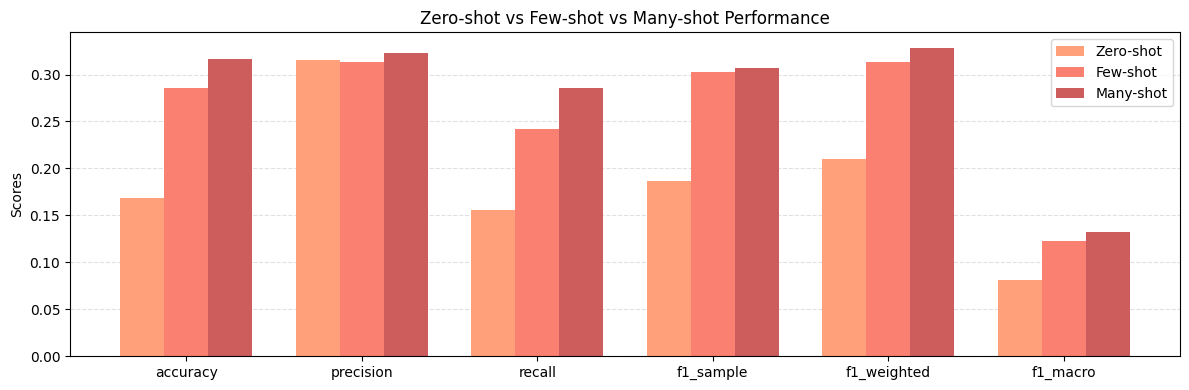

In [20]:
# visualize results
visualize_results(zero_shot_results_gpt4o_mini, few_shot_results_gpt4o_mini, many_shot_results_gpt4o_mini, colors_gpt4o_mini)

### GPT-4o

In [21]:
# === PARAMETERS ===
MODEL = "gpt-4o"

#### 1) Zero-Shot

In [22]:
# Run zero-shot prediction
print("Running zero-shot prediction...")
zero_shot_predictions_gpt4o = []
for sample in tqdm(first_look_test_data):
    prediction = zero_shot_predict(sample['image'])
    zero_shot_predictions_gpt4o.append(prediction)

Running zero-shot prediction...


100%|██████████| 25/25 [00:00<00:00, 2504.48it/s]


In [23]:
# Evaluate zero-shot results
zero_shot_results_gpt4o = evaluate(zero_shot_predictions_gpt4o, [sample['suffix'] for sample in first_look_test_data])
print("Zero-shot results:")
for key, value in zero_shot_results_gpt4o.items():
    print(f"{key}: {value}")


Zero-shot results:
bleu: 0.030494855199438196
rouge: 0.2055118992205308
accuracy: 0.1774891774891775
precision: 0.31911976911976914
recall: 0.15151515151515152
f1_sklearn: 0.18214155474155475
f1_sample: 0.18214155474155475
f1_weighted: 0.20414395609200803
f1_macro: 0.08317910879487234


#### 2) Few-Shot

In [24]:
# Run few-shot prediction
NUM_EXAMPLES = 5
print("\nRunning few-shot prediction...")
few_shot_predictions_gpt4o = []
for sample in tqdm(first_look_test_data[:VALIDATION_SIZE]):
    prediction = None
    attempts = 0
    max_attempts = 100
    while prediction is None and attempts < max_attempts:
        prediction = few_shot_predict(sample['image'], train_data[:NUM_EXAMPLES])
        attempts += 1
    if prediction:
        few_shot_predictions_gpt4o.append(prediction)
    else:
        print(f"Skipping sample after {max_attempts} failed attempts")


Running few-shot prediction...


100%|██████████| 25/25 [00:00<00:00, 347.34it/s]


In [25]:
# Evaluate few-shot results
if few_shot_predictions_gpt4o:
    few_shot_results_gpt4o = evaluate(few_shot_predictions_gpt4o, [sample['suffix'] for sample in first_look_test_data[:len(few_shot_predictions_gpt4o)]])
    print("Few-shot results:")
    for key, value in few_shot_results_gpt4o.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

Few-shot results:
bleu: 0.032270539270586054
rouge: 0.279888326759432
accuracy: 0.2943722943722944
precision: 0.3458707958707959
recall: 0.2554112554112554
f1_sklearn: 0.2849463056461557
f1_sample: 0.2849463056461557
f1_weighted: 0.3175836304810779
f1_macro: 0.13452340257948445


#### 3) Many-Shot

In [26]:
# Run many-shot prediction
NUM_EXAMPLES_MANY = 30
print("\nRunning many-shot prediction...")
many_shot_predictions_gpt4o = []
for sample in tqdm(first_look_test_data[:VALIDATION_SIZE]):
    prediction = None
    attempts = 0
    max_attempts = 100
    while prediction is None and attempts < max_attempts:
        prediction = few_shot_predict(sample['image'], train_data[:NUM_EXAMPLES_MANY])
        attempts += 1
    if prediction:
        many_shot_predictions_gpt4o.append(prediction)
    else:
        print(f"Skipping sample after {max_attempts} failed attempts")


Running many-shot prediction...


100%|██████████| 25/25 [00:00<00:00, 62.24it/s]


In [27]:
# Evaluate many-shot results
if many_shot_predictions_gpt4o:
    many_shot_results_gpt4o = evaluate(many_shot_predictions_gpt4o, [sample['suffix'] for sample in first_look_test_data[:len(many_shot_predictions_gpt4o)]])
    print("Many-shot results:")
    for key, value in many_shot_results_gpt4o.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

Many-shot results:
bleu: 0.030825224043968147
rouge: 0.2770804784121273
accuracy: 0.2857142857142857
precision: 0.33909690598002284
recall: 0.23809523809523808
f1_sklearn: 0.28134986620120367
f1_sample: 0.28134986620120367
f1_weighted: 0.3090929272747454
f1_macro: 0.12478034785727093


#### 4) Results

In [28]:
# Print some example predictions
print("\nExample predictions:")
for i in range(3):
    print(f"\nImage: {first_look_test_data[i]['image']}")
    print(f"Ground truth: {first_look_test_data[i]['suffix']}")
    print(f"Zero-shot prediction: {zero_shot_predictions_gpt4o[i]}")
    print(f"Few-shot prediction: {few_shot_predictions_gpt4o[i]}")
    print(f"Many-shot prediction: {many_shot_predictions_gpt4o[i]}")


Example predictions:

Image: data/food-101/images/red_velvet_cake/3749302.jpg
Ground truth: cake, sugar, cocoa, baking powder, salt, oil, butter, egg, red food coloring, vanilla, vinegar, butter, cheese, sugar, chocolate
Zero-shot prediction: Flour, sugar, eggs, butter, buttermilk, cocoa powder, red food coloring, vinegar, baking soda, cream cheese, powdered sugar, vanilla extract, crushed nuts.
Few-shot prediction: flour, sugar, cocoa powder, baking soda, salt, buttermilk, vegetable oil, eggs, red food coloring, vanilla extract, white vinegar, cream cheese, butter, powdered sugar, vanilla extract, chopped nuts
Many-shot prediction: flour, sugar, cocoa powder, baking soda, salt, buttermilk, vinegar, vanilla extract, red food coloring, vegetable oil, eggs, cream cheese, butter, powdered sugar, pecans

Image: data/food-101/images/carrot_cake/3175778.jpg
Ground truth: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk
Zero-shot pred

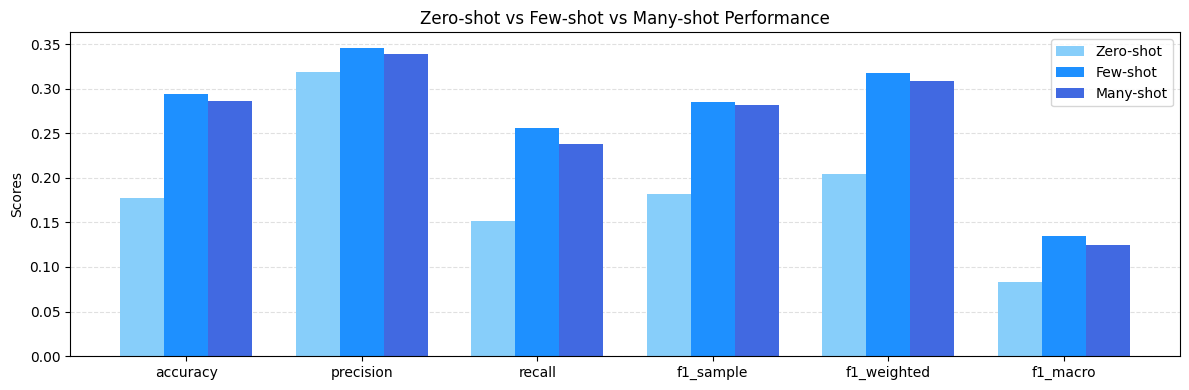

In [29]:
visualize_results(zero_shot_results_gpt4o, few_shot_results_gpt4o, many_shot_results_gpt4o, colors_gpt4o)


### GPT-4o vs. GPT-4o-mini (Early Trends)

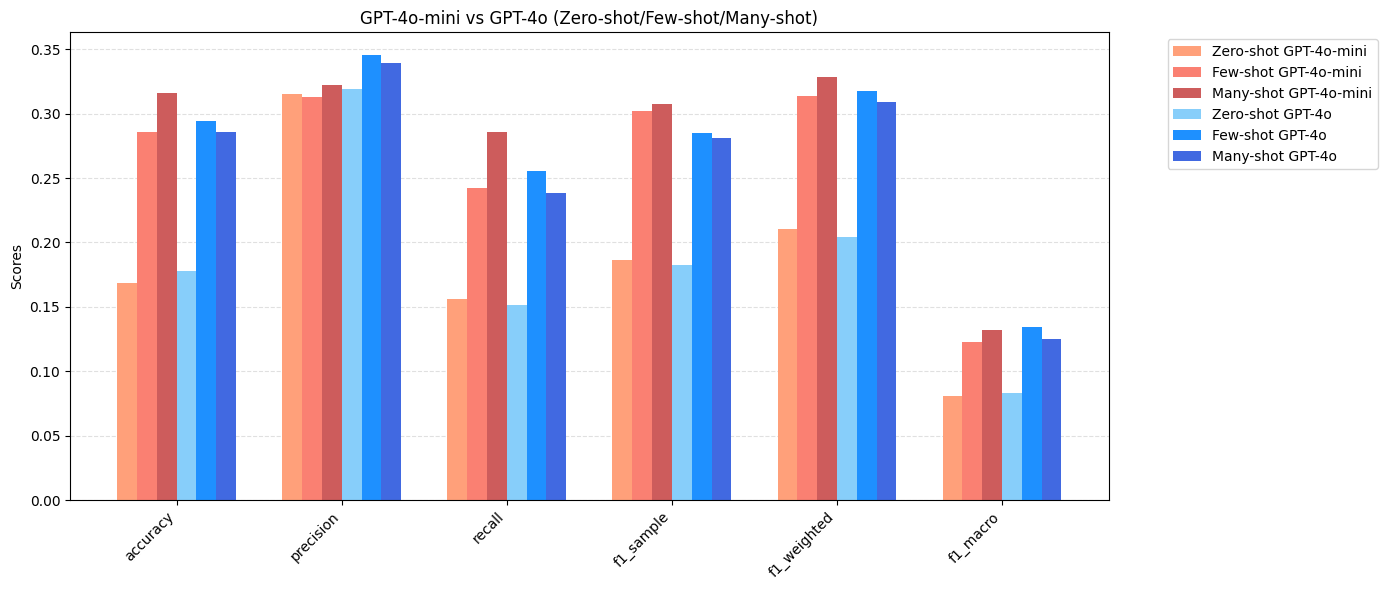

In [30]:
visualize_results(
    zero_shot_results_gpt4o_mini,
    few_shot_results_gpt4o_mini,
    many_shot_results_gpt4o_mini,
    colors_gpt4o_mini + colors_gpt4o,
    comparison=True,
    compare_results={
        "zero_shot": zero_shot_results_gpt4o,
        "few_shot": few_shot_results_gpt4o,
        "many_shot": many_shot_results_gpt4o
    }
)

In [37]:
# Usage example:
md_comparison_table(
    zero_shot_results_gpt4o_mini,
    few_shot_results_gpt4o_mini,
    many_shot_results_gpt4o_mini,
    zero_shot_results_gpt4o,
    few_shot_results_gpt4o,
    many_shot_results_gpt4o
)

| Metric | Zero-shot GPT-4o-mini | Few-shot GPT-4o-mini | Many-shot GPT-4o-mini | Zero-shot GPT-4o | Few-shot GPT-4o | Many-shot GPT-4o |
|--------|------------------------|------------------------|-------------------------|-------------------|------------------|-------------------|
| accuracy | 0.1688 | 0.2857 | 0.3160 | 0.1775 | 0.2944 | 0.2857 |
| precision | 0.3157 | 0.3128 | 0.3226 | 0.3191 | 0.3459 | 0.3391 |
| recall | 0.1558 | 0.2424 | 0.2857 | 0.1515 | 0.2554 | 0.2381 |
| f1_sample | 0.1867 | 0.3024 | 0.3072 | 0.1821 | 0.2849 | 0.2813 |
| f1_weighted | 0.2102 | 0.3137 | 0.3285 | 0.2041 | 0.3176 | 0.3091 |
| f1_macro | 0.0809 | 0.1231 | 0.1320 | 0.0832 | 0.1345 | 0.1248 |


> ## Erste Vergleichende Analyse GPT-4o-mini und GPT-4o
>
> Unsere Ergebnisse zeigen interessante Muster beim Vergleich von GPT-4o-mini und GPT-4o:
>
> 1. GPT-4o-mini übertrifft GPT-4o in Many-Shot-Szenarien bei Genauigkeit und Recall.
> 2. GPT-4o-mini zeigt konsistente Verbesserungen von Zero-Shot zu Many-Shot.
> 3. GPT-4o erreicht seine Höchstleistung in Few-Shot-Szenarien und zeigt einen leichten Rückgang bei Many-Shot.
> 4. Die Präzision bleibt bei beiden Modellen relativ stabil, während der Recall sich verbessert.
>
> Diese Muster deuten darauf hin, dass beide Modelle mit mehr Beispielen liberaler in der Vorhersage von Zutaten werden. Wichtige Überlegungen:
>
> 1. Unser vereinfachter Datensatz enthält nur Hauptzutaten.
> 2. Die Tendenz zur Vorhersage zusätzlicher Zutaten könnte in realen Anwendungen nützlich sein.
> 3. Zusätzlich vorhergesagte Zutaten könnten in den Gerichten vorhanden sein, wurden aber aus unseren Grundwahrheitsdaten herausgefiltert.
>
> ### Implikationen
>
> 1. Die Verbesserung des Recalls ist vorteilhaft und deutet auf eine bessere Identifizierung der Kernzutaten hin.
> 2. Die "Übervorhersage" von Zutaten könnte wertvolle zusätzliche Informationen liefern, wird aber in unseren aktuellen Metriken bestraft.
> 3. GPT-4o-mini zeigt bemerkenswerte Anpassungsfähigkeit, besonders in Many-Shot-Szenarien.
> 4. GPT-4o zeigt Anzeichen möglicher Überanpassung in Many-Shot-Szenarien.
>
> ### Zukünftige Arbeit
>
> 1. Qualitative Bewertung zusätzlich vorhergesagter Zutaten.
> 2. Verwendung eines umfassenderen Datensatzes für die abschließende Modellbewertung.
> 3. Untersuchung der Faktoren, die zu GPT-4o-minis überlegener Leistung in Many-Shot-Szenarien beitragen.
> 4. Analyse der Gründe für GPT-4o's Leistungsrückgang in Many-Shot-Szenarien.

# Closing Cache at the end of the script

Needed for data integrity and to free up resources

In [31]:
# close cache
cache.close()